### **Текстовое сопровождение задачи и подходов для хакатона**

---

#### **Постановка задачи**
Наша цель — спрогнозировать урожайность растений, используя их генотипические данные. Для этого мы разработали подход, который позволяет перевести биологические последовательности в числовые представления, а затем применить машинное обучение для создания предсказательной модели.

Урожайность растений определяется множеством факторов, включая генетические особенности, условия выращивания и климат. На хакатоне мы сосредоточились на анализе генотипических данных, чтобы выявить связи между последовательностями ДНК и продуктивностью растений.

---

#### **Методы построения фичей**
Для перевода биологических данных в цифровую форму мы использовали несколько ключевых этапов:

1. **Сбор и обработка генотипических данных**:
   - Данные представлены в формате VCF, содержащем информацию о референсных и альтернативных аллелях для каждой позиции генома.
   - Мы упорядочили данные по хромосоме и позиции, обработали пропуски (заменили на `N`), чтобы сохранить целостность последовательностей.

2. **Цифровизация последовательностей через `k-mers`**:
   - Длинные нуклеотидные последовательности были разбиты на подстроки фиксированной длины \( k \) (например, \( k=6 \)).
   - Эти `k-mers` представляют локальные паттерны в ДНК, которые могут быть связаны с функциональными регионами, влияющими на урожайность.

3. **Эмбеддинги с использованием Word2Vec**:
   - `k-mers` были преобразованы в числовые векторы с использованием модели Word2Vec, которая извлекает контекстные зависимости между ними.
   - Итоговое представление каждой последовательности — это усредненный вектор всех её `k-mers`. Это компактное числовое представление генотипов, готовое для использования в моделях машинного обучения.

---

#### **Методы анализа**
1. **Модели машинного обучения**:
   - Мы использовали Random Forest и CatBoost для построения модели, которая предсказывает урожайность на основе созданных эмбеддингов.
   - CatBoost, как градиентный бустинг, показал себя наиболее эффективно благодаря встроенной обработке числовых данных и оптимизации.

2. **Метрики оценки**:
   - Для оценки точности модели мы применили метрики MSE (среднеквадратическая ошибка) и \( R^2 \) (коэффициент детерминации).
   - Эти метрики помогли нам определить, насколько модель отражает реальные данные.

---

#### **Итог**
Мы продемонстрировали, как генетические данные могут быть цифровизированы и использованы для предсказания продуктивности растений. Этот подход:
- Основан на биологических закономерностях, таких как структура `k-mers` в ДНК.
- Применяет современные методы эмбеддингов для создания информативных фичей.
- Использует мощные модели машинного обучения для получения точных прогнозов.

---

#### **Краткая версия для презы**
- **Что мы сделали?**
  - Построили систему для предсказания урожайности растений на основе генотипических данных.
- **Как мы это сделали?**
  - Разбили последовательности ДНК на `k-mers` и обучили модель Word2Vec для их цифрового представления.
  - Объединили эти эмбеддинги с данными по урожайности и обучили модель CatBoost.
- **Почему это работает?**
  - Генетические особенности растений напрямую связаны с их продуктивностью.
  - `k-mers` и эмбеддинги позволяют извлекать скрытые паттерны в данных.
- **Что дальше?**
  - Добавление климатических факторов и других данных для улучшения точности.
  - Интеграция модели в практическое решение для агрономов.

---


In [1]:
!pip install catboost gensim pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [3]:
def wide_to_long(phenotypes_df:pd.DataFrame(),  value_vars:list, id_vars='sample') -> pd.DataFrame():
    """
    Преобразует широкую таблицу с таргетами в длинную.

    :param df: Исходный DataFrame в широком формате.
    :param id_vars: sample, которые остаются идентификаторами.
    :param value_vars: Года, которые нужно преобразовать в длинный формат.
    :return: DataFrame в длинном формате.
    """
    if value_vars is None:
        value_vars = ['2015', '2016', '2017', '2019', '2020', '2021', '2022', '2023']

    target_df = (pd.melt(phenotypes_df, id_vars=['sample'], value_vars=value_vars)
             .dropna()
             .rename(columns={'variable':'year',
                              'value':'yield'}
                    )
            )
    return target_df

In [6]:
raw_phenotypes = pd.read_csv('phenotypes.tsv', sep='\t')
target_data = wide_to_long(raw_phenotypes, ['2015', '2016', '2017', '2019', '2020', '2021', '2022', '2023'])
target_data['year'] = target_data['year'].astype(int)

In [95]:
target_data

,sample,year,yield
14,PS000076,2015,114.0
15,PS000033,2015,116.0
16,PS000048,2015,99.0
17,PS000191,2015,71.0
18,PS000077,2015,90.0
...,...,...,...
738,PS000069,2023,102.0
748,PS000444,2023,113.0
780,PS000433,2023,119.0
781,PS000056,2023,106.0


In [7]:

def read_vcf(file_path):
    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file if not line.startswith('##')]  # Пропускаем метаданные
    headers = lines[0].split('\t')  # Заголовки колонок
    data = [line.split('\t') for line in lines[1:]]  # Данные
    vcf_df = pd.DataFrame(data, columns=headers)
    return vcf_df

In [8]:
# чтение VCF файла
genotypes = read_vcf('genotypes.vcf')

In [9]:
def extract_allele(gt, ref, alt):
    if gt == "./.":  # Пропущенные данные
        return ""
    alleles = gt.split(":")[0].split("/")
    seq = "".join([ref if a == "0" else alt if a != "0" else "" for a in alleles])
    return seq

# разбиение последовательности на k-mers
def generate_kmers(sequence, k=6):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

In [10]:
# извлечение образцов и построение последовательностей
sample_columns = genotypes.columns[9:]
sample_sequences = {sample: '' for sample in sample_columns}

genotypes["POS"] = pd.to_numeric(genotypes["POS"], errors="coerce")
genotypes.sort_values(by=["#CHROM", "POS"], inplace=True)

for _, row in genotypes.iterrows():
    ref = row["REF"]
    alt = row["ALT"]

    for sample in sample_columns:
        allele_seq = extract_allele(row[sample], ref, alt)
        sample_sequences[sample] = ''.join([sample_sequences[sample], allele_seq])


In [11]:
k = 6  # Размер k-mers
kmers_samples = {sample: generate_kmers(seq, k=k) for sample, seq in sample_sequences.items()}
sentences = list(kmers_samples.values())

# обучение модели Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1, epochs=10)  # skip-gram


In [12]:
embeddings = []
for sample, kmers in kmers_samples.items():
  e = sum(w2v_model.wv[mer] for mer in kmers) / len(kmers) if kmers else None
  embeddings.append((sample, e))

embedding_df = pd.DataFrame(embeddings, columns=['sample', 'embeddings'])

embedding_df.head()

,sample,embeddings
0,PS000026,"[0.07594240070776014, 0.5262482784982054, -0.1..."
1,PS000027,"[0.0755026100518337, 0.5262800356807014, -0.15..."
2,PS000028,"[0.043203058405957756, 0.5399329180936396, -0...."
3,PS000031,"[0.07880383916803406, 0.524803531681822, -0.15..."
4,PS000033,"[0.07825274340636693, 0.5269543513367011, -0.1..."


In [13]:
embedding_df.to_json('embeddings.json')

In [16]:
weather_features = pd.read_json('res_meteo.json')
weather_features

,year,avg_day_temp_prorastanie,min_day_temp_prorastanie,max_day_temp_prorastanie,avg_soil_moisture_100_to_255cm_prorastanie,sum_rain_prorastanie,avg_temperature_soil_prorastanie,avg_cloud_cover_high_prorastanie,gtd_prorastanie,avg_day_temp_vshody,...,avg_cloud_cover_high_sozrevanie,gtd_sozrevanie,avg_day_temp_ubor_urozhaya,min_day_temp_ubor_urozhaya,max_day_temp_ubor_urozhaya,avg_soil_moisture_100_to_255cm_ubor_urozhaya,sum_rain_ubor_urozhaya,avg_temperature_soil_ubor_urozhaya,avg_cloud_cover_high_ubor_urozhaya,gtd_ubor_urozhaya
0,2015,13.138658,5.3,20.0,0.290658,22.6,3.567093,39.792332,0.067655,16.515335,...,33.006390,0.081230,19.362168,8.2,32.9,0.275742,18.3,15.545226,20.774587,0.006868
1,2016,13.591693,3.7,23.3,0.329380,17.8,4.793291,19.731629,0.049618,14.440895,...,23.607029,0.011541,20.101364,8.0,32.6,0.319661,77.8,16.677459,24.563532,0.028275
2,2017,12.376997,-0.3,24.7,0.350853,16.4,3.969010,24.249201,0.052334,13.256230,...,35.127796,0.023734,20.121823,9.1,34.6,0.322632,87.4,16.301866,23.254128,0.031321
3,2019,13.782428,2.4,23.1,0.337000,58.6,3.468371,50.099042,0.150635,16.472843,...,32.814696,0.058430,18.192247,6.4,29.8,0.318362,56.5,14.731443,32.773151,0.022746
4,2020,12.373163,3.3,21.7,0.312879,51.6,4.763259,45.619808,0.169064,9.612780,...,21.456869,0.102393,18.276095,6.1,30.8,0.298314,58.8,14.854989,29.348169,0.023602
5,2021,11.126518,3.0,20.1,0.313358,38.8,3.623962,43.102236,0.153524,16.161981,...,24.287540,0.040587,18.928930,2.9,32.9,0.292525,98.5,15.815578,33.090452,0.039208
6,2022,10.307987,1.0,23.4,0.385188,6.0,3.306390,28.418530,0.027634,11.013738,...,35.824281,0.129285,18.005312,2.3,29.9,0.349775,134.1,14.574731,49.607322,0.057281
7,2023,9.465176,-0.9,23.7,0.383489,4.7,3.645367,47.405751,0.025762,17.253035,...,36.808307,0.026014,18.794472,6.1,32.5,0.346394,143.2,14.663101,27.843503,0.055999


In [17]:
cols = [
    'year',
    'embeddings',
    'avg_day_temp_prorastanie',
    'min_day_temp_prorastanie',
    'max_day_temp_prorastanie',
    'avg_soil_moisture_100_to_255cm_prorastanie',
    'sum_rain_prorastanie',
    'avg_temperature_soil_prorastanie',
    'avg_cloud_cover_high_prorastanie',
    'gtd_prorastanie',
    'avg_day_temp_vshody',
    'min_day_temp_vshody',
    'max_day_temp_vshody',
    'avg_soil_moisture_100_to_255cm_vshody',
    'sum_rain_vshody',
    'avg_temperature_soil_vshody',
    'avg_cloud_cover_high_vshody',
    'gtd_vshody',
    'avg_day_temp_veg_faza',
    'min_day_temp_veg_faza',
    'max_day_temp_veg_faza',
    'avg_soil_moisture_100_to_255cm_veg_faza',
    'sum_rain_veg_faza',
    'avg_temperature_soil_veg_faza',
    'avg_cloud_cover_high_veg_faza',
    'gtd_veg_faza',
    'avg_day_temp_cvetenie',
    'min_day_temp_cvetenie',
    'max_day_temp_cvetenie',
    'avg_soil_moisture_100_to_255cm_cvetenie',
    'sum_rain_cvetenie',
    'avg_temperature_soil_cvetenie',
    'avg_cloud_cover_high_cvetenie',
    'gtd_cvetenie',
    'avg_day_temp_form_bobov',
    'min_day_temp_form_bobov',
    'max_day_temp_form_bobov',
    'avg_soil_moisture_100_to_255cm_form_bobov',
    'sum_rain_form_bobov',
    'avg_temperature_soil_form_bobov',
    'avg_cloud_cover_high_form_bobov',
    'gtd_form_bobov',
    'avg_day_temp_sozrevanie',
    'min_day_temp_sozrevanie',
    'max_day_temp_sozrevanie',
    'avg_soil_moisture_100_to_255cm_sozrevanie',
    'sum_rain_sozrevanie',
    'avg_temperature_soil_sozrevanie',
    'avg_cloud_cover_high_sozrevanie',
    'gtd_sozrevanie',
    'avg_day_temp_ubor_urozhaya',
    'min_day_temp_ubor_urozhaya',
    'max_day_temp_ubor_urozhaya',
    'avg_soil_moisture_100_to_255cm_ubor_urozhaya',
    'sum_rain_ubor_urozhaya',
    'avg_temperature_soil_ubor_urozhaya',
    'avg_cloud_cover_high_ubor_urozhaya',
    'gtd_ubor_urozhaya'
]

In [18]:

# Объединяем с данными по урожайности
merged_data = pd.merge(target_data, embedding_df, on="sample", how="inner")
merged_data = pd.merge(merged_data, weather_features, on="year", how="inner")

# Разделение на признаки и целевую переменную
X = merged_data.drop(columns=["sample", "yield"], axis=1)
X = X[cols]
y = merged_data["yield"]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
X

,year,embeddings,avg_day_temp_prorastanie,min_day_temp_prorastanie,max_day_temp_prorastanie,avg_soil_moisture_100_to_255cm_prorastanie,sum_rain_prorastanie,avg_temperature_soil_prorastanie,avg_cloud_cover_high_prorastanie,gtd_prorastanie,...,avg_cloud_cover_high_sozrevanie,gtd_sozrevanie,avg_day_temp_ubor_urozhaya,min_day_temp_ubor_urozhaya,max_day_temp_ubor_urozhaya,avg_soil_moisture_100_to_255cm_ubor_urozhaya,sum_rain_ubor_urozhaya,avg_temperature_soil_ubor_urozhaya,avg_cloud_cover_high_ubor_urozhaya,gtd_ubor_urozhaya
0,2015,"[0.12076630924301981, 0.5948474658666202, -0.1...",13.138658,5.3,20.0,0.290658,22.6,3.567093,39.792332,0.067655,...,33.006390,0.081230,19.362168,8.2,32.9,0.275742,18.3,15.545226,20.774587,0.006868
1,2015,"[0.12653799385196535, 0.5931824149081135, -0.1...",13.138658,5.3,20.0,0.290658,22.6,3.567093,39.792332,0.067655,...,33.006390,0.081230,19.362168,8.2,32.9,0.275742,18.3,15.545226,20.774587,0.006868
2,2015,"[0.12462742028116786, 0.5912513588706317, -0.1...",13.138658,5.3,20.0,0.290658,22.6,3.567093,39.792332,0.067655,...,33.006390,0.081230,19.362168,8.2,32.9,0.275742,18.3,15.545226,20.774587,0.006868
3,2015,"[0.12323418589836646, 0.5922268006677771, -0.1...",13.138658,5.3,20.0,0.290658,22.6,3.567093,39.792332,0.067655,...,33.006390,0.081230,19.362168,8.2,32.9,0.275742,18.3,15.545226,20.774587,0.006868
4,2015,"[0.12348670125437805, 0.5925309922445947, -0.1...",13.138658,5.3,20.0,0.290658,22.6,3.567093,39.792332,0.067655,...,33.006390,0.081230,19.362168,8.2,32.9,0.275742,18.3,15.545226,20.774587,0.006868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2023,"[0.12120435594503502, 0.5939810286782095, -0.1...",9.465176,-0.9,23.7,0.383489,4.7,3.645367,47.405751,0.025762,...,36.808307,0.026014,18.794472,6.1,32.5,0.346394,143.2,14.663101,27.843503,0.055999
355,2023,"[0.13029327831772652, 0.5824221898146371, -0.1...",9.465176,-0.9,23.7,0.383489,4.7,3.645367,47.405751,0.025762,...,36.808307,0.026014,18.794472,6.1,32.5,0.346394,143.2,14.663101,27.843503,0.055999
356,2023,"[0.1222746237916766, 0.5859469850505997, -0.12...",9.465176,-0.9,23.7,0.383489,4.7,3.645367,47.405751,0.025762,...,36.808307,0.026014,18.794472,6.1,32.5,0.346394,143.2,14.663101,27.843503,0.055999
357,2023,"[0.12553332449626328, 0.593958624474048, -0.12...",9.465176,-0.9,23.7,0.383489,4.7,3.645367,47.405751,0.025762,...,36.808307,0.026014,18.794472,6.1,32.5,0.346394,143.2,14.663101,27.843503,0.055999


In [ ]:
# Обучение модели Random Forest
# model = RandomForestRegressor(random_state=42, n_estimators=100)
# model.fit(X_train, y_train)

# # Предсказания и оценка
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error (MSE):", mse)
# print("R^2 Score:", r2)

In [19]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [20]:
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "embedding_features": ['embeddings']
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

[I 2024-11-24 06:25:16,748] A new study created in memory with name: no-name-d91a2466-ce9a-4265-b45c-dcd86332299a
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-24 06:25:22,032] Trial 0 finished with value: 15.225375405187886 and parameters: {'learning_rate': 0.000801112091389934, 'depth': 7, 'subsample': 0.7436890349182192, 'colsample_bylevel': 0.7341835251406997, 'min_data_in_leaf': 31}. Best is trial 0 with value: 15.225375405187886.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-24 06:25:24,052] Trial 1 finished with value: 15.387965299603062

In [21]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Обучение модели CatBoost
catboost_model = CatBoostRegressor(
    **study.best_params
)

catboost_model.fit(X_train, y_train, embedding_features=['embeddings'], eval_set=(X_test, y_test), verbose=100)

# Предсказания и оценка
y_pred_cb = catboost_model.predict(X_test)
mse_cb = mean_squared_error(y_test, y_pred_cb)
r2_cb = r2_score(y_test, y_pred_cb)

print("CatBoost Mean Squared Error (MSE):", mse_cb)
print("CatBoost R^2 Score:", r2_cb)



0:	learn: 15.9224852	test: 15.4321848	best: 15.4321848 (0)	total: 2.75ms	remaining: 2.75s
100:	learn: 15.5249431	test: 15.0956445	best: 15.0830981 (62)	total: 13.6ms	remaining: 121ms
200:	learn: 15.3891565	test: 14.9802617	best: 14.9802617 (200)	total: 30.8ms	remaining: 122ms
300:	learn: 15.2818933	test: 14.8375190	best: 14.8375190 (300)	total: 56.1ms	remaining: 130ms
400:	learn: 15.1686825	test: 14.6608085	best: 14.6608085 (400)	total: 88ms	remaining: 131ms
500:	learn: 15.1305128	test: 14.6520861	best: 14.6229153 (490)	total: 123ms	remaining: 123ms
600:	learn: 15.0766788	test: 14.6907404	best: 14.6156360 (557)	total: 149ms	remaining: 99ms
700:	learn: 15.0366624	test: 14.6604898	best: 14.6156360 (557)	total: 180ms	remaining: 76.8ms
800:	learn: 15.0067867	test: 14.6309810	best: 14.6156360 (557)	total: 207ms	remaining: 51.4ms
900:	learn: 14.9766324	test: 14.6155483	best: 14.6095227 (836)	total: 231ms	remaining: 25.4ms
999:	learn: 14.9523125	test: 14.6400916	best: 14.6095227 (836)	total: 

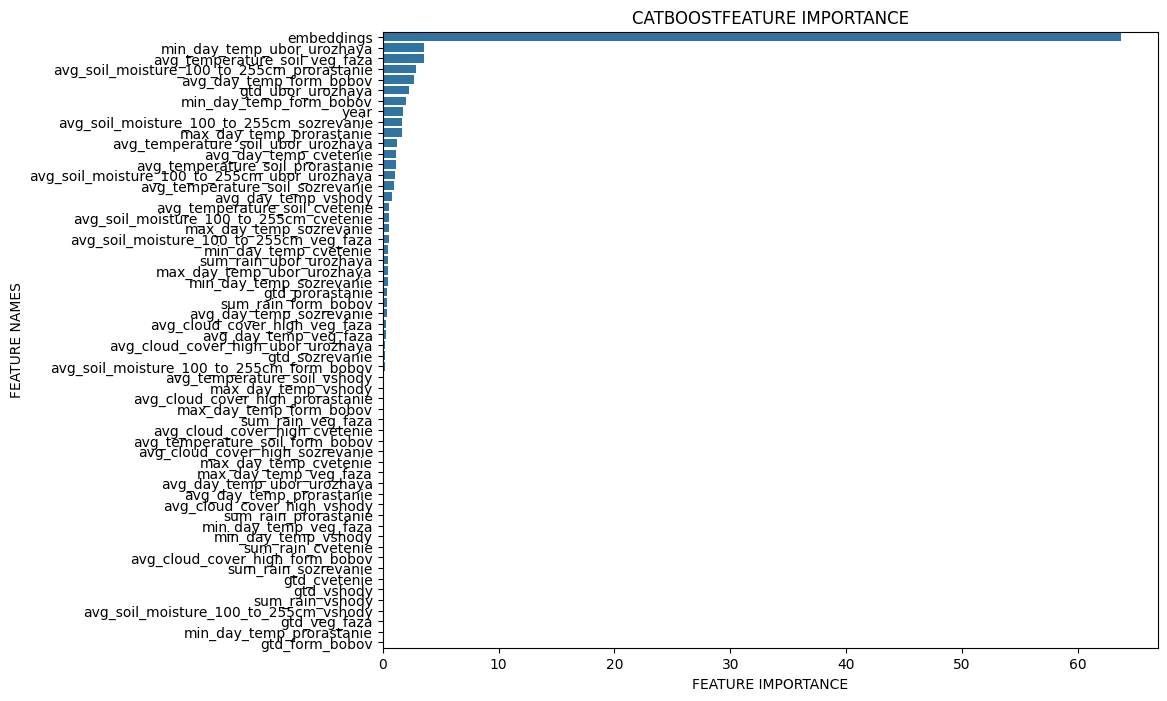

In [22]:
from catboost import Pool
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost_model.get_feature_importance(),X_train.columns,'CATBOOST')

In [23]:
catboost_model.save_model('weights.cbm')

In [53]:
X_test.columns.tolist()

['year',
 'embeddings',
 'avg_day_temp_prorastanie',
 'min_day_temp_prorastanie',
 'max_day_temp_prorastanie',
 'avg_soil_moisture_100_to_255cm_prorastanie',
 'sum_rain_prorastanie',
 'avg_temperature_soil_prorastanie',
 'avg_cloud_cover_high_prorastanie',
 'gtd_prorastanie',
 'avg_day_temp_vshody',
 'min_day_temp_vshody',
 'max_day_temp_vshody',
 'avg_soil_moisture_100_to_255cm_vshody',
 'sum_rain_vshody',
 'avg_temperature_soil_vshody',
 'avg_cloud_cover_high_vshody',
 'gtd_vshody',
 'avg_day_temp_veg_faza',
 'min_day_temp_veg_faza',
 'max_day_temp_veg_faza',
 'avg_soil_moisture_100_to_255cm_veg_faza',
 'sum_rain_veg_faza',
 'avg_temperature_soil_veg_faza',
 'avg_cloud_cover_high_veg_faza',
 'gtd_veg_faza',
 'avg_day_temp_cvetenie',
 'min_day_temp_cvetenie',
 'max_day_temp_cvetenie',
 'avg_soil_moisture_100_to_255cm_cvetenie',
 'sum_rain_cvetenie',
 'avg_temperature_soil_cvetenie',
 'avg_cloud_cover_high_cvetenie',
 'gtd_cvetenie',
 'avg_day_temp_form_bobov',
 'min_day_temp_form_bobo